In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import joblib

# %matplotlib notebook
from matplotlib import pyplot as plt

from os.path import join
from jupyter_utils.progress_bar import ProgressBar
from functools import partial

from nabirds import CUB_Annotations, NAB_Annotations
from nabirds.dataset import PartMixin, PreExtractedFeaturesMixin, AnnotationsReadMixin
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from scipy.ndimage.filters import gaussian_filter

from chainer.training import StandardUpdater, Trainer, extensions
from chainer.iterators import SerialIterator
from chainer.dataset.convert import concat_examples
from chainer.optimizer_hooks import Lasso # L1 regularization

from chainer_addons.models import InceptionV3
from chainer_addons.training import optimizer, lr_shift, JupyterProgressBar

import chainer
import chainer.functions as F
import chainer.links as L
from chainer.cuda import to_cpu

chainer.__version__

'4.2.0'

In [3]:
BASE_DIR = "/home/korsch/Data"

infos = dict(
    
    # VGG19 Features
    
    NAC_single=dict(
        data="NAC/2017-bilinear",
        feat_suffix="10parts_new"
    ),
    
    NAC_vgg=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts"
    ),
    
    
    # ResNet50 Features
    
    NAC_resnet=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts.resnet"
    ),
    
    GT_resnet=dict(
        data="cub200_11",
        feat_suffix="16parts_gt.resnet"
    ),
    
    # InceptionV3 Features
    
    NAC_inception=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts.inception"
    ),
    GT_inception=dict(
        data="cub200_11",
        feat_suffix="16parts_gt.inception"
    ),
    
    GT2_inception=dict(
        data="cub200_11_regrouped",
        feat_suffix="5parts_gt.inception"
    )
)
DATASET="NAC_inception"
info = infos[DATASET]
DATA_DIR = join(BASE_DIR, "DATASETS", "birds", info["data"])

EPS = 1e-3

In [4]:
class Dataset(PartMixin, PreExtractedFeaturesMixin, AnnotationsReadMixin):
    
    def get_example(self, i):
        im_obj = super(Dataset, self).get_example(i)
        return im_obj.feature[-1], im_obj.label

In [5]:
print("Loading annotations from \"{}\"...".format(DATA_DIR))
annot = CUB_Annotations(DATA_DIR)

print("Creating train and test datasets")
splits = [annot.train_uuids, annot.test_uuids]
features = [join(DATA_DIR, "features", "{}_{}.npz".format(s, info["feat_suffix"])) 
            for s in ["train", "val"]]

train, val = [Dataset(uuids=s, annotations=annot, features=feats) 
               for s, feats in zip(splits, features)]

Loading annotations from "/home/korsch/Data/DATASETS/birds/NAC/2017-bilinear"...
Creating train and test datasets


In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

scaler = MinMaxScaler()
scaler.fit(train.features[:, -1])

train.features[:, -1] = scaler.transform(train.features[:, -1])
val.features[:, -1] = scaler.transform(val.features[:, -1])

In [7]:
if False:
    _init_clf = LinearSVC(penalty="l1", C=1, dual=False, max_iter=10000)
    print("Fitting L1 SVM ...")
    %time _init_clf.fit(train.features[:, -1], train.labels)
else:
    _init_clf = None
    print("No initial SVM is trained!")

No initial SVM is trained!


In [8]:
if _init_clf is not None:
    print("L1 SVM Accuracy: {:.3%}".format(_init_clf.score(val.features[:, -1], val.labels)))
    print("SVM coef sparsity:", (_init_clf.coef_ == 0).mean())

In [9]:
class Classifier(chainer.Chain):
    def __init__(self, n_classes=200, **kwargs):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.fc = L.Linear(2048, n_classes, **kwargs)
        
    def __call__(self, X, y):
        pred = self.fc(X)
        
        accu = F.accuracy(pred, y)
        #loss = F.softmax_cross_entropy(pred, y)
        # squared hinge loss
        loss = F.hinge(pred, y)
        
        bin_W = self.xp.abs(self.fc.W.data) <= EPS
        
        chainer.report(dict(
            accu=accu, 
            loss=loss,
            sparsity=self.xp.mean(bin_W)
        ), self)
        
        return loss
if _init_clf is not None:
    clf = Classifier(initialW=_init_clf.coef_, initial_bias=_init_clf.intercept_)
else:
    clf = Classifier(
        initialW=chainer.initializers.Uniform(1), 
        initial_bias=0)

In [10]:
GPU = 0
BATCH_SIZE = None

OPTIMIZER="sgd"

if BATCH_SIZE is None:
    LR, LRS, LRD, LRT = 1, 200, 0.5, 1e-5
else:
    LR, LRS, LRD, LRT = 5e-3, 5, 0.1, 1e-5

In [11]:
train_it = SerialIterator(train, batch_size=BATCH_SIZE or len(train), repeat=True, shuffle=True)
val_it = SerialIterator(val, batch_size=BATCH_SIZE or len(val), repeat=False, shuffle=False)


opt = optimizer(OPTIMIZER, clf, lr=LR, decay=0, gradient_clipping=False)
opt.add_hook(Lasso(rate=1e-3))

updater = StandardUpdater(train_it, opt, device=GPU)
evaluator = extensions.Evaluator(val_it, clf, device=GPU)

interval = (20, "epoch")

trainer = Trainer(updater, stop_trigger=(1000, "epoch"), out=".out")

trainer.extend(evaluator, trigger=interval)

lr_shift_ext = lr_shift(opt,
    init=LR, rate=LRD, target=LRT)
trainer.extend(lr_shift_ext, trigger=(LRS, 'epoch'))

_weights = []
def save_weights(trainer):
    global _weights
    
    model = trainer.updater.get_optimizer("main").target
    _weights.append(to_cpu(model.fc.W.data))

trainer.extend(save_weights, trigger=interval)
trainer.extend(extensions.observe_lr(), trigger=interval)
trainer.extend(extensions.LogReport(trigger=interval))

report_values = [
    # "elapsed_time",
    "epoch",
    "lr",

    "main/sparsity",
    
    "main/accu",
    "{0.default_name}/main/accu".format(evaluator),

    "main/loss",
    "{0.default_name}/main/loss".format(evaluator)
]

trainer.extend(extensions.PrintReport(report_values), trigger=interval)

trainer.extend(JupyterProgressBar(update_interval=5))

In [12]:
trainer.run()

epoch       lr          main/sparsity  main/accu   validation/main/accu  main/loss   validation/main/loss
20          1           0.00109021     0.017042    0.0510873             72.3856     65.4223               
40          1           0.00284155     0.180305    0.316534              44.5446     26.7429               
60          1           0.0106964      0.660769    0.757335              9.46873     4.39723               
80          1           0.0464683      0.982015    0.837073              0.27783     1.97445               
100         1           0.124433       0.996613    0.819986              0.0576563   1.47291               
120         1           0.211164       0.991091    0.806179              0.14392     1.25953               
140         1           0.264255       0.94844     0.773041              0.684368    1.90435               
160         1           0.292995       0.92706     0.79427               1.1148      1.50285               
180         1           0.3164

In [13]:
from matplotlib import animation
from IPython.display import display, HTML
from skimage.transform import resize
from functools import partial

def animate(images, scale=2., dpi=100.0):
    """
        Creates a HTML5 videos from a sequence of images
    """
    images = np.array(images)
    n, w, h = images.shape[:3]

    f_w, f_h = fig_shape = (scale * w, int(scale * w * 16 / 9))
    resizer = partial(resize, output_shape=fig_shape, mode="constant")
    
    fig_kwargs = dict(figsize=(f_h / dpi, f_w / dpi), dpi=dpi)
    fig, ax = plt.subplots(**fig_kwargs)
    ax.axis("off")
    
    # fig_shape = (int(h * 16 / 9), h)
    im0 = resizer(images[0])
    im = ax.imshow(im0, vmin=images.min(), vmax=images.max())
#     im = plt.figimage(im0, vmin=images.min(), vmax=images.max(), origin="upper")
    text = ax.text(0, -10, "Epoch 0")

    def inner(i):
        im0 = resizer(images[i])
        text.set_text("Epoch {: 3d}".format(i * interval[0]))
        im.set_data(im0)
        return (im,)
    
    anim = animation.FuncAnimation(fig, inner, frames=len(images))
    display(HTML(anim.to_html5_video()))
    
    plt.close()

In [17]:
# animate([F.normalize(w).array for w in _weights])
# animate(_weights)
animate([np.abs(w) > 1e-2 for w in _weights])

In [15]:
weights = to_cpu(clf.fc.W.data)
print(weights.min(), weights.max())
bin_weights = np.abs(weights) > 1e-2#EPS

-0.46238768 1.157845


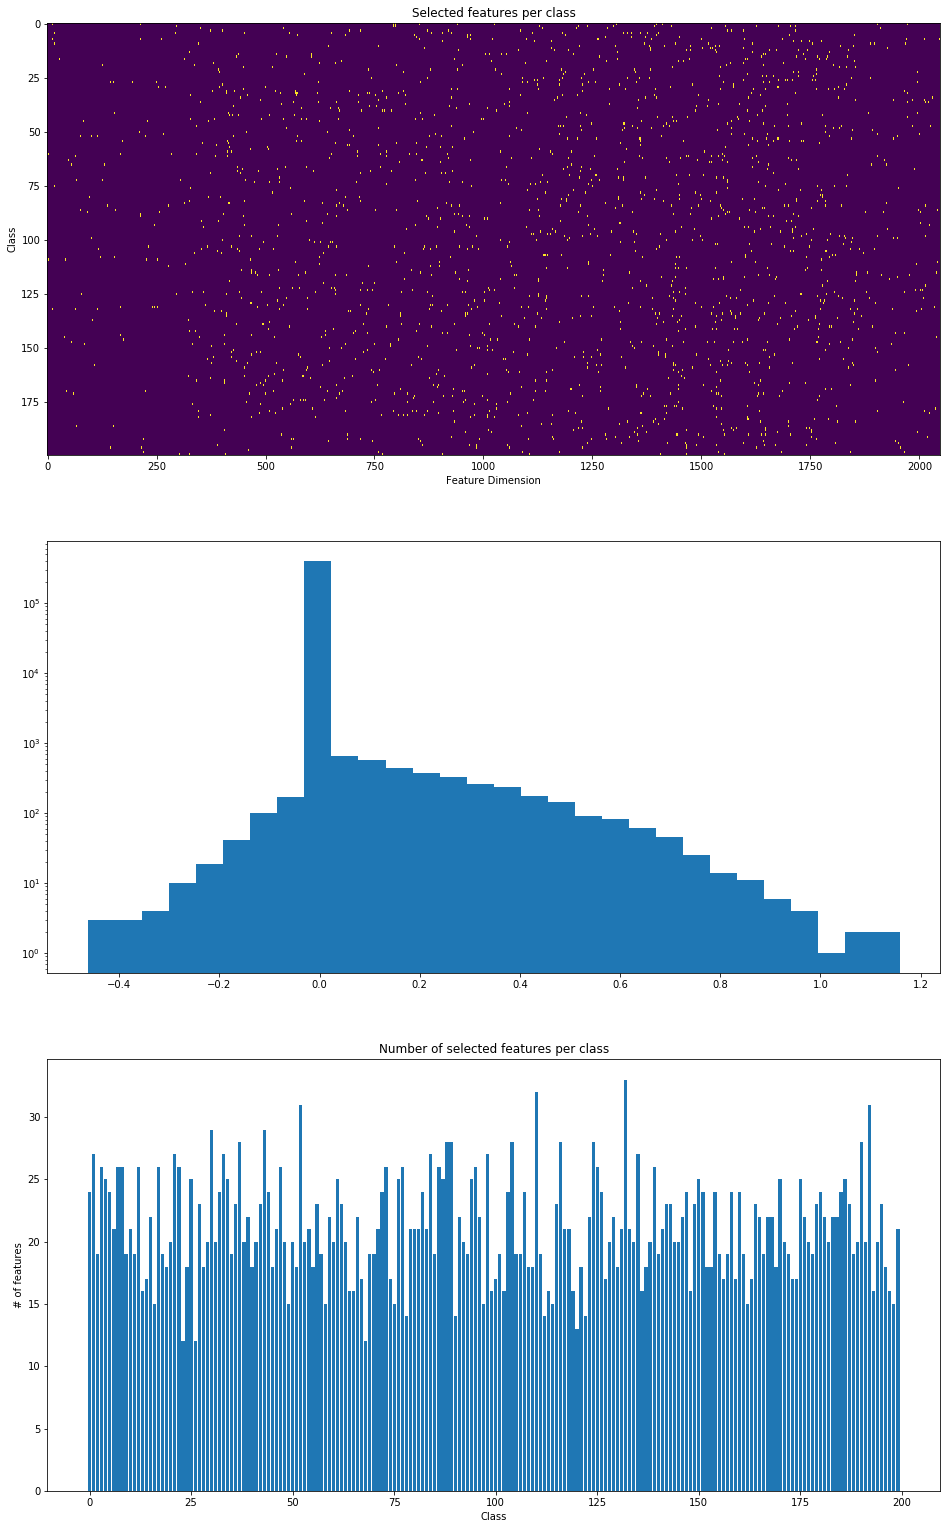

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,1, figsize=(16, 3*9))
axs[0].set_title("Selected features per class")
axs[0].set_xlabel("Feature Dimension")
axs[0].set_ylabel("Class")
axs[0].imshow(bin_weights, aspect="auto")

axs[1].hist(weights.ravel(), bins=30)
axs[1].set_yscale("log")

axs[2].set_title("Number of selected features per class")
axs[2].set_xlabel("Class")
axs[2].set_ylabel("# of features")
axs[2].bar(np.arange(len(weights)), bin_weights.sum(axis=1))

plt.show()
plt.close()